## Cactus Classifier with fastai.vision

This dataset is perfect for beginners, because the problem is literally trying to find stick-like patterns.Also fastai.vision library gives score 1 with little to no effort.
I've tried densenet and resnet here and they both give perfect score. 

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch


In [2]:
data_folder = Path("../input")
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/sample_submission.csv")

In [3]:
test_img = ImageList.from_df(test_df, path=data_folder/'test', folder='test')

In [4]:
src = (ImageList.from_df(train_df, path=data_folder/'train', folder='train')
        .split_by_rand_pct(0.01)
        .label_from_df()
        .add_test(test_img)
       )

In [5]:
train_img=src.databunch('.',bs=50)

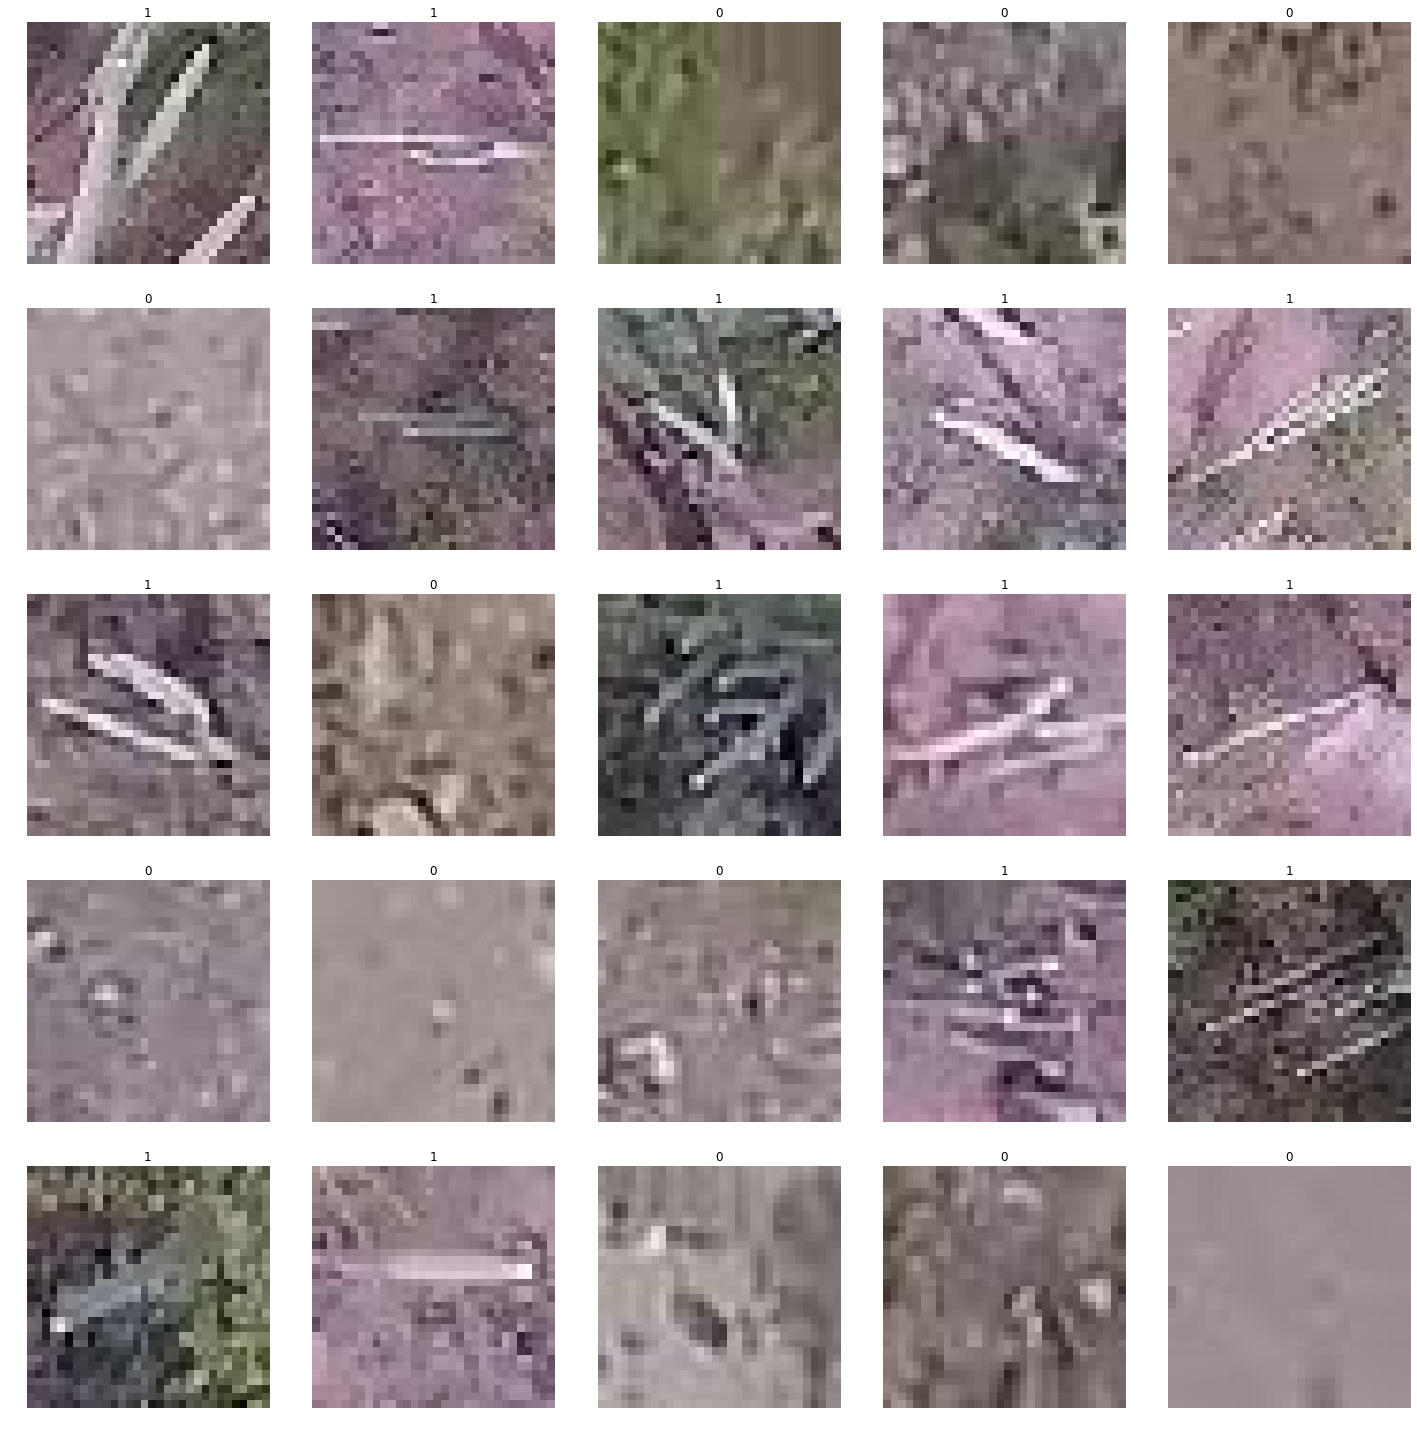

In [6]:
train_img.show_batch()

## Transforms

From the competetion details, we know these images were taken from air. So they resemble satelite imagery. Looking at the images though, they are very low resolution and look very ugly when blown up :D

Anyways, some features are apparent from looking at the data:
1. Some pictures are flipped vertically.
2. Some are rotated.
3. Some are zoomed in and some aren't.

Lucky for us, fastai has some default transforms ready. All we need to do is to plug them in. Default transforms include zooms, rotations and lighting.
I'm just adding vertical flip in to account for aerial imagery.

In [7]:
tfms=get_transforms(flip_vert=True)

In [8]:
train_img = (src.transform(tfms,size=128)
            .databunch('.',bs=50)
       )

## Training Densenet

In [9]:
denselearner = cnn_learner(train_img, models.densenet161, metrics=[FBeta(),error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /tmp/.torch/models/densenet161-8d451a50.pth
115730790it [00:02, 44135406.44it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03


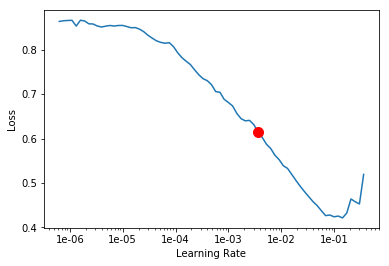

In [10]:
denselearner.lr_find()
denselearner.recorder.plot(suggestion=True)

In [11]:
lr = 7.5e-03
denselearner.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,f_beta,error_rate,accuracy,time
0,0.044712,0.010914,0.993641,0.005714,0.994286,01:38
1,0.016908,0.003916,1.000000,0.000000,1.000000,01:32
2,0.034826,0.000676,1.000000,0.000000,1.000000,01:32
3,0.007519,0.000120,1.000000,0.000000,1.000000,01:32
4,0.007383,0.000125,1.000000,0.000000,1.000000,01:32


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Failed to compute the gradients, there might not be enough points.


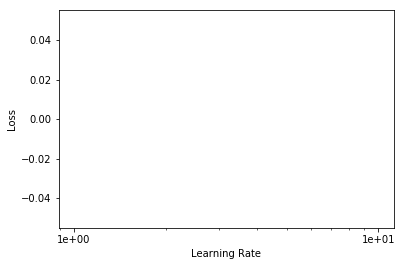

In [12]:
denselearner.unfreeze()
denselearner.lr_find()
denselearner.recorder.plot(suggestion=True)

In [13]:
denselearner.fit_one_cycle(1, slice(1e-06))

epoch,train_loss,valid_loss,f_beta,error_rate,accuracy,time
0,0.006447,0.000068,1.000000,0.000000,1.000000,01:52


## Training Resnet
Densenet takes quite a lot of time considering this problem is trivial. Bit of an overkill to be honest.
Let's try Resnet.

In [14]:
reslearner = cnn_learner(train_img, models.resnet101, metrics=[FBeta(),error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /tmp/.torch/models/resnet101-5d3b4d8f.pth
178728960it [00:10, 16903714.36it/s]


In [15]:
reslearner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-04


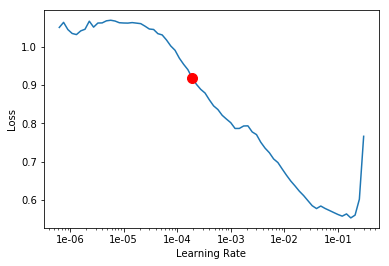

In [16]:
reslearner.recorder.plot(suggestion=True)

In [17]:
lr=9e-3

In [18]:
reslearner.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,f_beta,error_rate,accuracy,time
0,0.063169,0.033260,0.992063,0.011429,0.988571,01:17
1,0.034835,0.002770,1.000000,0.000000,1.000000,01:15
2,0.024171,0.002123,1.000000,0.000000,1.000000,01:15
3,0.014281,0.006416,0.998415,0.005714,0.994286,01:14
4,0.006923,0.002465,1.000000,0.000000,1.000000,01:13


In [19]:
reslearner.unfreeze()
reslearner.fit_one_cycle(2,slice(1e-6))

epoch,train_loss,valid_loss,f_beta,error_rate,accuracy,time
0,0.006819,0.004229,1.000000,0.000000,1.000000,01:23
1,0.006326,0.004271,0.998415,0.005714,0.994286,01:23


Resnet converges to 100% accuracy very quickly.
Plotting losses and watching confusion matrix is of no need.

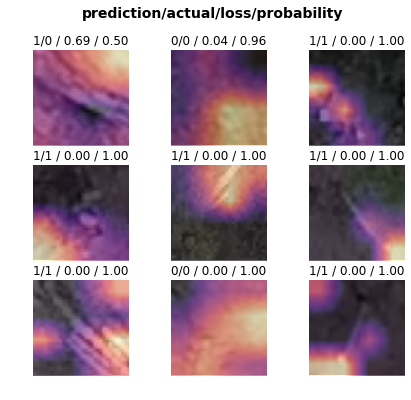

In [20]:
interp = ClassificationInterpretation.from_learner(reslearner)
interp.plot_top_losses(9, figsize=(7,6))

In [21]:
preds,_ = reslearner.get_preds(ds_type=DatasetType.Test)

In [22]:
test_df.has_cactus = preds.numpy()[:, 0]

In [23]:
test_df.to_csv('submission.csv', index=False)